<a href="https://colab.research.google.com/github/romenlaw/llm_playground/blob/main/emb_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!rm *.jpg *.png
!wget -q -O brick.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Brick.jpg/250px-Brick.jpg
!wget -q -O lab_ret.png https://www.purina.com.au/dw/image/v2/BKFD_PRD/on/demandware.static/-/Library-Sites-purina-shared-library/default/dw597f2b33/images/Finding-a-pet/Pet-breeds/Dog-breeds/Labrador%20Retriever.png
!wget -q -O dog.jpg https://thornleighvet.com.au/wp-content/uploads/sites/102/2024/05/why-you-should-castrate-your-dog.jpg
!wget -q -O dog_grass.jpg https://dogshome.com/wp-content/uploads/animalimages//1145009/51c54fd0d04b417380074df5717dd9d6-1747271460-1747271505_srch.jpg
!wget -q -O carp.png https://environmentagency.blog.gov.uk/wp-content/uploads/sites/84/2022/05/prussian-carp.png
!wget -q -O fish_grass.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Balantiocheilos_melanopterus_-_Karlsruhe_Zoo_02_%28cropped%29.jpg/250px-Balantiocheilos_melanopterus_-_Karlsruhe_Zoo_02_%28cropped%29.jpg


In [15]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
import numpy as np

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to generate image embedding
def get_image_embedding(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt", padding=True)

    # Generate embedding
    with torch.no_grad():
        image_embedding = model.get_image_features(**inputs)
    return image_embedding.numpy()

In [16]:
directory = "./"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
files

['dog_grass.jpg',
 'dog.jpg',
 'lab_ret.png',
 'fish_grass.jpg',
 'carp.png',
 'brick.jpg']

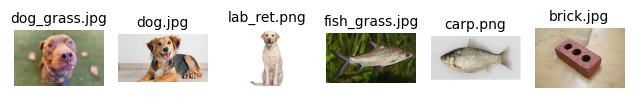

In [17]:
# axes = plt.subplots(1, len(files), figsize=(10,10))
for i, file in enumerate(files):
  img = Image.open(file)
  plt.subplot(1, len(files), i + 1)
  plt.imshow(img)
  plt.title(os.path.basename(file), fontsize=10)
  plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
embs = []
for file in files:
  image_embedding = get_image_embedding(file)
  embs.append(image_embedding.flatten())

embs = np.array(embs)

In [19]:
embs.shape

(6, 512)

In [20]:
norms = np.linalg.norm(embs, axis=1, keepdims=True)
normalized_emb = embs / np.maximum(norms, 1e-10)  # Avoid division by zero

# Compute pairwise cosine similarity
similarity_matrix = np.dot(normalized_emb, normalized_emb.T)

In [21]:
similarity_matrix

array([[0.99999964, 0.7539673 , 0.70138097, 0.46290118, 0.43215197,
        0.43737552],
       [0.7539673 , 1.0000001 , 0.85618424, 0.4813783 , 0.5084039 ,
        0.4765444 ],
       [0.70138097, 0.85618424, 1.0000005 , 0.5386428 , 0.5619528 ,
        0.5407975 ],
       [0.46290118, 0.4813783 , 0.5386428 , 0.9999997 , 0.8522132 ,
        0.49655092],
       [0.43215197, 0.5084039 , 0.5619528 , 0.8522132 , 0.99999994,
        0.47883952],
       [0.43737552, 0.4765444 , 0.5407975 , 0.49655092, 0.47883952,
        1.        ]], dtype=float32)

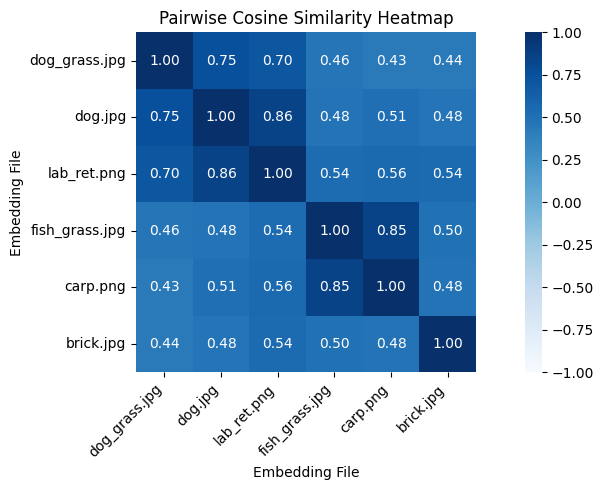

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(
    similarity_matrix,
    annot=True,  # Show similarity values
    cmap="Blues",  # Color map (green to yellow)
    vmin=-1, vmax=1,  # Cosine similarity range
    square=True,  # Square cells
    fmt=".2f",  # Format values to 2 decimal places
    xticklabels=files,
    yticklabels=files
)
plt.xticks(rotation=45, ha='right')
plt.title("Pairwise Cosine Similarity Heatmap")
plt.xlabel("Embedding File")
plt.ylabel("Embedding File")
plt.tight_layout()
plt.show()

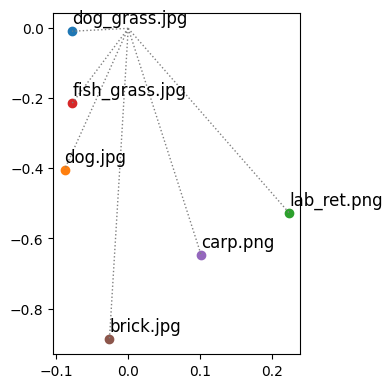

In [23]:
dim = embs.shape[1]
plt.figure(figsize=(4,4))
x, y = np.random.randint(0, dim), np.random.randint(0, dim)

for emb, file in zip(embs, files):
  plt.scatter(emb[x], emb[y], label=file)
  plt.text(emb[x], emb[y] + 0.01, file, ha='left', va='bottom', fontsize=12)
  plt.plot([0, emb[x]], [0, emb[y]], color='gray', linestyle=':', linewidth=1)

plt.tight_layout()
plt.show()

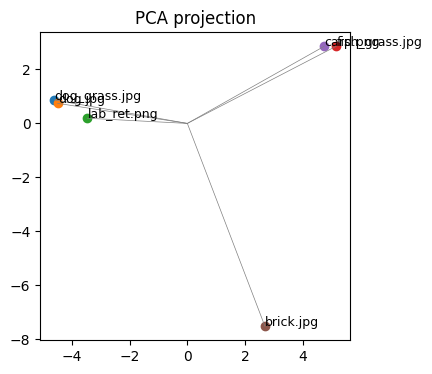

In [24]:
import matplotlib.pyplot as plt

## PCA
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(embs)
plt.figure(figsize=(4,4))

for i, label in enumerate(files):
    x, y = X_pca[i,0], X_pca[i,1]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.plot([0, x], [0, y], color='gray', linestyle='-', linewidth=0.5)

plt.title('PCA projection')
plt.show()

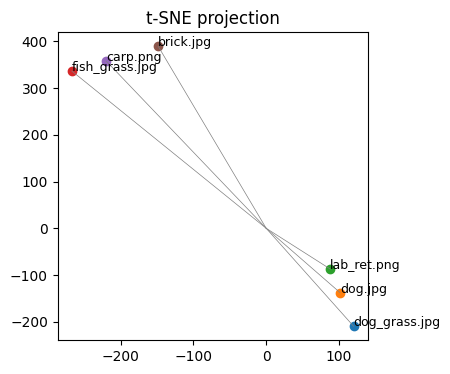

In [30]:
from sklearn.manifold import TSNE

perplexity = min(30, len(files) - 1)/4  # or set any value < n_samples
X_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(embs)

plt.figure(figsize=(4,4))

for i, label in enumerate(files):
    x, y = X_tsne[i,0], X_tsne[i,1]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.plot([0, x], [0, y], color='gray', linestyle='-', linewidth=0.5)

plt.title('t-SNE projection')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


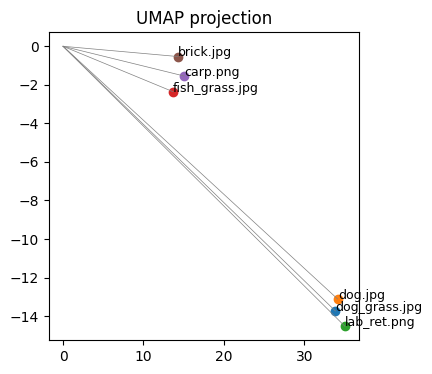

In [36]:
import umap

X_umap = umap.UMAP(n_components=3, n_neighbors=2, min_dist=1,
                   random_state=42).fit_transform(embs)

plt.figure(figsize=(4,4))

for i, label in enumerate(files):
    x, y = X_umap[i,0], X_umap[i,1]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.plot([0, x], [0, y], color='gray', linestyle='-', linewidth=0.5)

plt.title('UMAP projection')
plt.show()